In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from natsort import natsorted

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import ResNet50V2, Xception
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

In [2]:
train_path = "data/train_set/"
val_path = "data/val_set/"

In [3]:
IMG_WIDTH = 224
IMG_HEIGHT = 224
BATCH_SIZE = 32

In [4]:
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.inception_v3.preprocess_input
)
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 9528 images belonging to 15 classes.


In [5]:
validation_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.inception_v3.preprocess_input
)
validation_generator = validation_datagen.flow_from_directory(
    val_path,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 2382 images belonging to 15 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


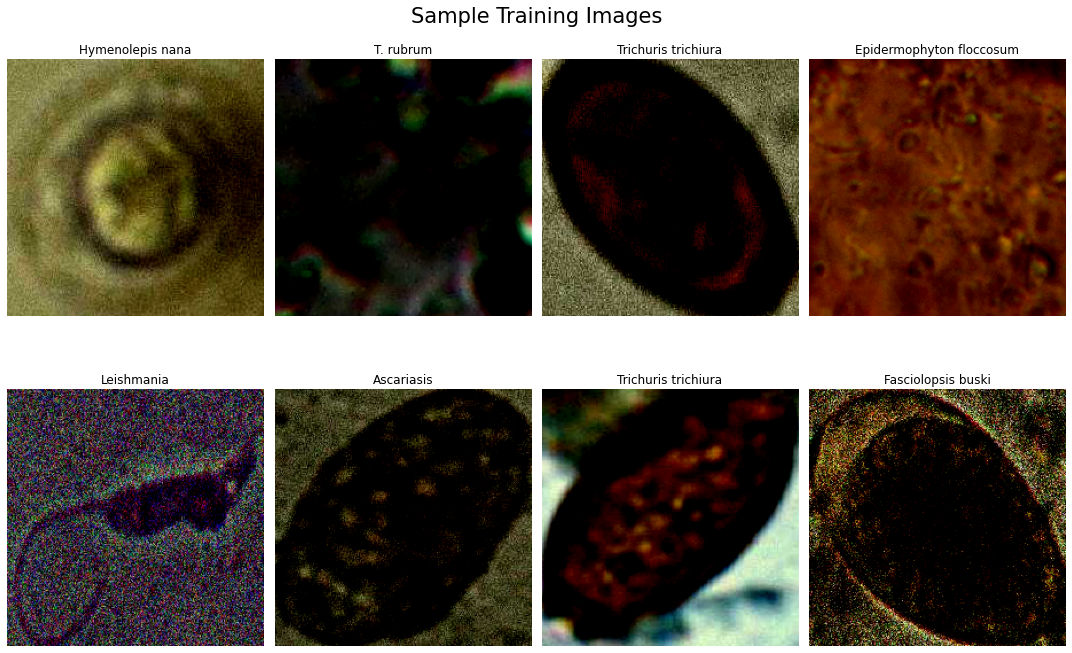

In [6]:
labels = {value: key for key, value in train_generator.class_indices.items()}

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(15, 10))
idx = 0

for i in range(2):
    for j in range(4):
        label = labels[np.argmax(train_generator[0][1][idx])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_generator[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Sample Training Images", fontsize=21)
plt.show()

In [8]:
resnet_model = Sequential()

pretrained_model= ResNet50V2(
    include_top=False,
    weights="imagenet",
    input_shape=(IMG_WIDTH, IMG_HEIGHT, 3),
    pooling='avg',
    classes=15
)

for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)

resnet_model.add(Flatten())

resnet_model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.001)))
resnet_model.add(Dropout(0.5))
resnet_model.add(Dense(15, activation='softmax'))

In [9]:
print(resnet_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               1049088   
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 15)                7695      
                                                                 
Total params: 24621583 (93.92 MB)
Trainable params: 1056783 (4.03 MB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________
None


In [10]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-7)

In [11]:
resnet_model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
history = resnet_model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/10
298/298 [==============================] - 771s 3s/step - loss: 1.2652 - accuracy: 0.7541 - val_loss: 0.8242 - val_accuracy: 0.8602 - lr: 0.0010
Epoch 2/10
298/298 [==============================] - 747s 3s/step - loss: 0.7797 - accuracy: 0.8565 - val_loss: 0.6872 - val_accuracy: 0.8799 - lr: 0.0010
Epoch 3/10
298/298 [==============================] - 747s 3s/step - loss: 0.6759 - accuracy: 0.8724 - val_loss: 0.6341 - val_accuracy: 0.8837 - lr: 0.0010
Epoch 4/10
298/298 [==============================] - 769s 3s/step - loss: 0.6009 - accuracy: 0.8896 - val_loss: 0.6297 - val_accuracy: 0.8795 - lr: 0.0010
Epoch 5/10
298/298 [==============================] - 730s 2s/step - loss: 0.5653 - accuracy: 0.8953 - val_loss: 0.5828 - val_accuracy: 0.8913 - lr: 0.0010
Epoch 6/10
298/298 [==============================] - 712s 2s/step - loss: 0.5584 - accuracy: 0.9022 - val_loss: 0.5628 - val_accuracy: 0.9068 - lr: 0.0010
Epoch 7/10
298/298 [==============================] - 714s 2s/st

In [13]:
history = resnet_model.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/5
298/298 [==============================] - 779s 3s/step - loss: 0.3420 - accuracy: 0.9585 - val_loss: 0.4571 - val_accuracy: 0.9173 - lr: 2.0000e-04
Epoch 2/5
298/298 [==============================] - 855s 3s/step - loss: 0.3185 - accuracy: 0.9611 - val_loss: 0.4422 - val_accuracy: 0.9160 - lr: 2.0000e-04
Epoch 3/5
298/298 [==============================] - 824s 3s/step - loss: 0.2970 - accuracy: 0.9661 - val_loss: 0.4338 - val_accuracy: 0.9144 - lr: 2.0000e-04
Epoch 4/5
298/298 [==============================] - 783s 3s/step - loss: 0.2810 - accuracy: 0.9663 - val_loss: 0.4147 - val_accuracy: 0.9198 - lr: 2.0000e-04
Epoch 5/5
298/298 [==============================] - 821s 3s/step - loss: 0.2726 - accuracy: 0.9667 - val_loss: 0.4047 - val_accuracy: 0.9152 - lr: 2.0000e-04


In [17]:
history = resnet_model.fit(
    train_generator,
    epochs=2,
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/2
298/298 [==============================] - 968s 3s/step - loss: 0.2541 - accuracy: 0.9706 - val_loss: 0.4007 - val_accuracy: 0.9190 - lr: 2.0000e-04
Epoch 2/2
298/298 [==============================] - 1005s 3s/step - loss: 0.2513 - accuracy: 0.9696 - val_loss: 0.3932 - val_accuracy: 0.9135 - lr: 2.0000e-04


In [11]:
history = resnet_model.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator,
    callbacks=EarlyStopping(
        monitor='val_loss',  
        patience=2,      
        restore_best_weights=True  
    ),
    verbose=1
)

Epoch 1/10
298/298 [==============================] - 893s 3s/step - loss: 0.5553 - accuracy: 0.8187 - val_loss: 0.4398 - val_accuracy: 0.8615
Epoch 2/10
298/298 [==============================] - 977s 3s/step - loss: 0.2328 - accuracy: 0.9204 - val_loss: 0.3185 - val_accuracy: 0.8963
Epoch 3/10
298/298 [==============================] - 921s 3s/step - loss: 0.1543 - accuracy: 0.9463 - val_loss: 0.3222 - val_accuracy: 0.8955
Epoch 4/10
298/298 [==============================] - 818s 3s/step - loss: 0.0954 - accuracy: 0.9678 - val_loss: 0.3252 - val_accuracy: 0.9026
Epoch 5/10
298/298 [==============================] - 924s 3s/step - loss: 0.0570 - accuracy: 0.9823 - val_loss: 0.2969 - val_accuracy: 0.9148
Epoch 6/10
298/298 [==============================] - 956s 3s/step - loss: 0.0495 - accuracy: 0.9840 - val_loss: 0.3221 - val_accuracy: 0.9106
Epoch 7/10
298/298 [==============================] - 937s 3s/step - loss: 0.0488 - accuracy: 0.9850 - val_loss: 0.3514 - val_accuracy: 0.9047

In [15]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

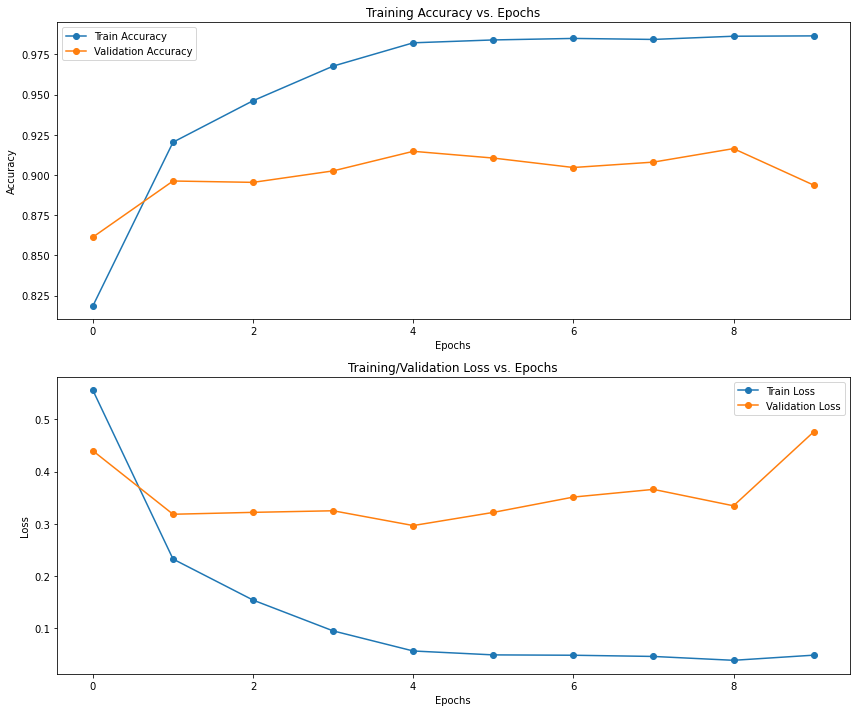

In [24]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

plt.tight_layout()
plt.savefig('images/ResNet50V2 Evaluation.jpg', dpi=300, format='jpg')
plt.show()

In [20]:
resnet_model.save(f'models/ResNet50V2-{round(max(train_accuracy), 4)}ACC-{round(min(train_loss), 4)}LOSS.h5')

C:\Users\Kershrita\AppData\Roaming\Python\Python39\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Submission

In [18]:
test_data_dir = 'data/test_data'

test_image_files = natsorted([os.path.join(test_data_dir, file) for file in os.listdir(test_data_dir) if file.endswith(('jpg', 'jpeg', 'png'))])
predictions = []

for image_path in test_image_files:
    img = load_img(image_path, target_size=(IMG_WIDTH, IMG_HEIGHT))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) 

    img_array = tf.keras.applications.resnet_v2.preprocess_input(img_array)

    prediction = resnet_model.predict(img_array)
    predictions.append(prediction[0])  

predictions = np.array(predictions)

submission_df = pd.DataFrame(predictions, columns=['class_0', 'class_1', 'class_2', 'class_3', 'class_4', 'class_5', 'class_6', 'class_7', 'class_8', 'class_9', 'class_10', 'class_11', 'class_12', 'class_13', 'class_14'])

submission_df['image_name'] = [os.path.basename(file) for file in test_image_files]
submission_df = submission_df[['image_name', 'class_0', 'class_1', 'class_2', 'class_3', 'class_4', 'class_5', 'class_6', 'class_7', 'class_8', 'class_9', 'class_10', 'class_11', 'class_12', 'class_13', 'class_14']]

1/1 [==============================] - 0s 194ms/step


1/1 [==============================] - 0s 135ms/step


1/1 [==============================] - 0s 178ms/step


1/1 [==============================] - 0s 188ms/step


1/1 [==============================] - 0s 164ms/step


1/1 [==============================] - 0s 140ms/step


1/1 [==============================] - 0s 168ms/step


1/1 [==============================] - 0s 151ms/step


1/1 [==============================] - 0s 178ms/step


1/1 [==============================] - 0s 168ms/step


1/1 [==============================] - 0s 187ms/step


1/1 [==============================] - 0s 181ms/step


1/1 [==============================] - 0s 231ms/step


1/1 [==============================] - 0s 252ms/step


1/1 [==============================] - 0s 235ms/step


1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 0s 270ms/step


In [19]:
submission_df.to_csv('data/ResNet_Submission.csv', index=False)

## Xception

In [4]:
xtrain_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.xception.preprocess_input
)
xtrain_generator = xtrain_datagen.flow_from_directory(
    train_path,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 9528 images belonging to 15 classes.


In [5]:
xvalidation_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.xception.preprocess_input
)
xvalidation_generator = xvalidation_datagen.flow_from_directory(
    val_path,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 2382 images belonging to 15 classes.


In [6]:
labels = {value: key for key, value in xtrain_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : Ascariasis
1 : Babesia
2 : Capillaria p
3 : Enterobius v
4 : Epidermophyton floccosum
5 : Fasciolopsis buski
6 : Hookworm egg
7 : Hymenolepis diminuta
8 : Hymenolepis nana
9 : Leishmania
10 : Opisthorchis viverrine
11 : Paragonimus spp
12 : T. rubrum
13 : Taenia spp
14 : Trichuris trichiura


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


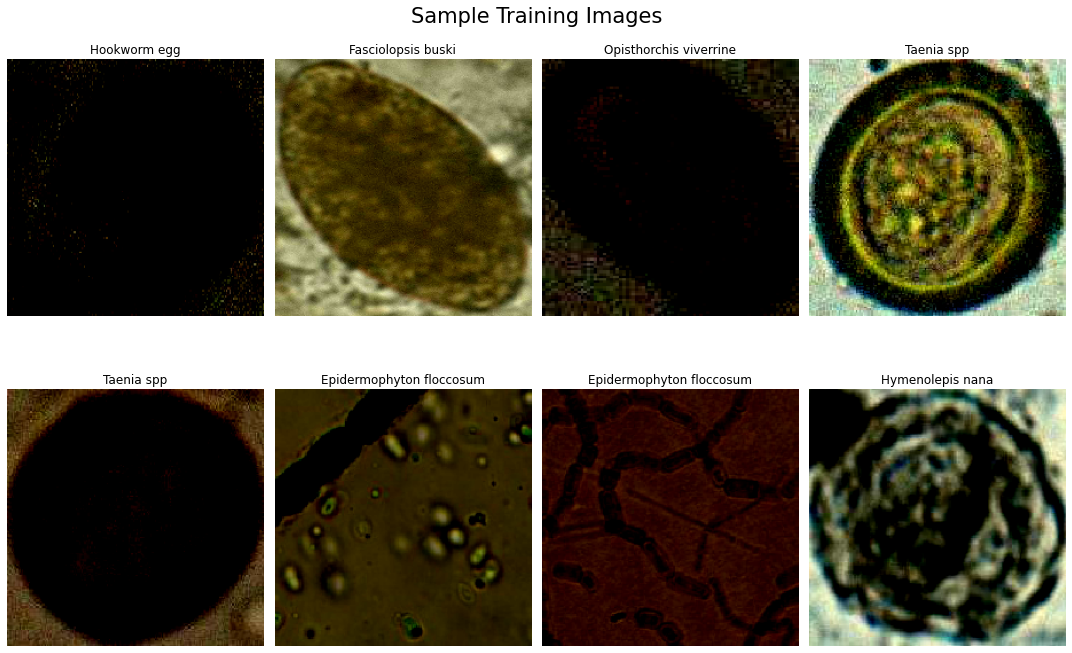

In [7]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(15, 10))
idx = 0

for i in range(2):
    for j in range(4):
        label = labels[np.argmax(xtrain_generator[0][1][idx])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(xtrain_generator[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Sample Training Images", fontsize=21)
plt.show()

In [8]:
xception_model = Sequential()

pretrained_model= tf.keras.applications.Xception(
    include_top=False,
    weights="imagenet",
    input_shape=(IMG_WIDTH, IMG_HEIGHT, 3),
    pooling='avg',
    classes=15
)

for layer in pretrained_model.layers:
        layer.trainable=False

xception_model.add(pretrained_model)
xception_model.add(Flatten())
xception_model.add(Dense(512, activation='relu'))
xception_model.add(Dense(15, activation='softmax'))

In [9]:
print(xception_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 15)                7695      
                                                                 
Total params: 21918263 (83.61 MB)
Trainable params: 1056783 (4.03 MB)
Non-trainable params: 20861480 (79.58 MB)
_________________________________________________________________
None


In [10]:
xception_model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
xhistory = xception_model.fit(
    xtrain_generator,
    validation_data=xvalidation_generator,
    callbacks=EarlyStopping(
        monitor='val_loss',  
        patience=3,      
        restore_best_weights=True  
    ),
    epochs=5
)

Epoch 1/5
298/298 [==============================] - 797s 3s/step - loss: 0.6003 - accuracy: 0.8024 - val_loss: 0.4157 - val_accuracy: 0.8581
Epoch 2/5
298/298 [==============================] - 802s 3s/step - loss: 0.2792 - accuracy: 0.9019 - val_loss: 0.3445 - val_accuracy: 0.8808
Epoch 3/5
298/298 [==============================] - 778s 3s/step - loss: 0.1885 - accuracy: 0.9349 - val_loss: 0.3175 - val_accuracy: 0.8917
Epoch 4/5
298/298 [==============================] - 805s 3s/step - loss: 0.1449 - accuracy: 0.9492 - val_loss: 0.3157 - val_accuracy: 0.8950
Epoch 5/5
298/298 [==============================] - 833s 3s/step - loss: 0.1070 - accuracy: 0.9631 - val_loss: 0.3046 - val_accuracy: 0.9043


In [12]:
xtrain_accuracy = xhistory.history['accuracy']
xval_accuracy = xhistory.history['val_accuracy']

xtrain_loss = xhistory.history['loss']
xval_loss = xhistory.history['val_loss']

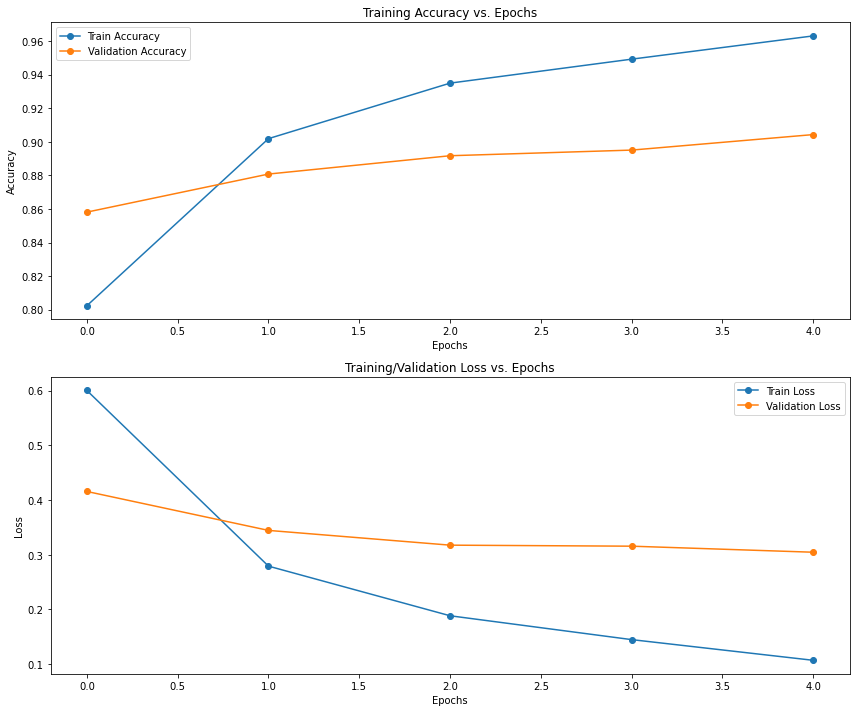

In [19]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(xtrain_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(xval_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(xtrain_loss, 'o-', label='Train Loss')
ax[1].plot(xval_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

plt.tight_layout()
plt.savefig('images/Xception Evaluation.jpg', dpi=300, format='jpg')
plt.show()

In [14]:
xception_model.save(f'models/XCEPTION-{round(max(xtrain_accuracy), 4)}ACC-{round(min(xtrain_loss), 4)}LOSS.h5')

C:\Users\Kershrita\AppData\Roaming\Python\Python39\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Submission

In [17]:
test_data_dir = 'data/test_data'

test_image_files = natsorted([os.path.join(test_data_dir, file) for file in os.listdir(test_data_dir) if file.endswith(('jpg', 'jpeg', 'png'))])
predictions = []

for image_path in test_image_files:
    img = load_img(image_path, target_size=(IMG_WIDTH, IMG_HEIGHT))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) 

    img_array = tf.keras.applications.xception.preprocess_input(img_array)

    prediction = xception_model.predict(img_array)
    predictions.append(prediction[0])  

predictions = np.array(predictions)

submission_df = pd.DataFrame(predictions, columns=['class_0', 'class_1', 'class_2', 'class_3', 'class_4', 'class_5', 'class_6', 'class_7', 'class_8', 'class_9', 'class_10', 'class_11', 'class_12', 'class_13', 'class_14'])

submission_df['image_name'] = [os.path.basename(file) for file in test_image_files]
submission_df = submission_df[['image_name', 'class_0', 'class_1', 'class_2', 'class_3', 'class_4', 'class_5', 'class_6', 'class_7', 'class_8', 'class_9', 'class_10', 'class_11', 'class_12', 'class_13', 'class_14']]

1/1 [==============================] - 0s 132ms/step


1/1 [==============================] - 0s 122ms/step


1/1 [==============================] - 0s 112ms/step


1/1 [==============================] - 0s 120ms/step


1/1 [==============================] - 0s 119ms/step


1/1 [==============================] - 0s 128ms/step


1/1 [==============================] - 0s 140ms/step


1/1 [==============================] - 0s 140ms/step


1/1 [==============================] - 0s 136ms/step


1/1 [==============================] - 0s 128ms/step


1/1 [==============================] - 0s 136ms/step


1/1 [==============================] - 0s 132ms/step


1/1 [==============================] - 0s 180ms/step


1/1 [==============================] - 0s 148ms/step


1/1 [==============================] - 0s 148ms/step


1/1 [==============================] - 0s 156ms/step


1/1 [==============================] - 0s 153ms/step


In [18]:
submission_df.to_csv('data/Xception_Submission.csv', index=False)